In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from enum import Enum
import numpy as np
import random

In [2]:
# Створення small-world графа
undirected_graph = nx.watts_strogatz_graph(n=300, k=30, p=0.35, seed=1)

graph = nx.DiGraph()
graph.add_nodes_from(undirected_graph.nodes)

for u, v in undirected_graph.edges:
    if random.random() < 0.5:
        graph.add_edge(u, v)
    else:
        graph.add_edge(v, u)

graph.remove_edges_from(nx.selfloop_edges(graph))


In [3]:
class State(Enum):
    SOURCE_A = 0
    SOURCE_B = 1
    SUSCEPTIBLE = 2
    INFECTED_A = 3
    INFECTED_B = 4
    RECOVERED = 5

# STATE2COLOR = {
#     State.SOURCE_A: "red",
#     State.SOURCE_B: "blue",
#     State.SUSCEPTIBLE: "#cccccc",
#     State.INFECTED_A: "orange",
#     State.INFECTED_B: "#5478b3",
#     State.RECOVERED: "green"
# }

STATE2COLOR = {
    State.SOURCE_A: "#801313",     # яскраво-червоний
    State.SOURCE_B: "#030980",     # насичений синій
    State.SUSCEPTIBLE: "#bdbdbd",  # сірий (нейтральний)
    State.INFECTED_A: "#f2306e",   # помаранчевий (теплий, як у SOURCE_A)
    State.INFECTED_B: "#3095f2",   # глибокий синій (холодний, як у SOURCE_B)
    State.RECOVERED: "#035e03"     # зелений (як символ стабілізації/одужання)
}


In [4]:
np.random.seed(1)

# Джерела A і B
sources_A = [3, 5, 7, 11, 13]
sources_B = [217, 223, 229, 231, 237, 284, 299]

for node in graph.nodes:
    if node in sources_A:
        graph.nodes[node]["state"] = State.SOURCE_A
        graph.nodes[node]["resistance"] = 0
    elif node in sources_B:
        graph.nodes[node]["state"] = State.SOURCE_B
        graph.nodes[node]["resistance"] = 0
    else:
        graph.nodes[node]["state"] = State.SUSCEPTIBLE
        graph.nodes[node]["resistance"] = np.random.random()

    # Випадкова довіра
    trust_a = np.random.uniform(0.3, 0.7)
    graph.nodes[node]["trust_A"] = trust_a
    graph.nodes[node]["trust_B"] = 1 - trust_a

In [5]:
# fig, ax = plt.subplots()
# position = nx.spring_layout(graph, seed=5)

# node_colors = [STATE2COLOR[graph.nodes[n]["state"]] for n in graph.nodes]

# nx.draw_networkx_nodes(graph, position, ax=ax, node_color=node_colors, edgecolors="black", node_size=500)
# nx.draw_networkx_edges(graph, position, ax=ax, arrows=True)

# plt.title("Initial Small-World Graph with Two Sources")
# plt.axis("off")
# plt.show()


In [6]:
def change_states(graph, graph_copy, node):
    node_state = graph.nodes[node]["state"]

    if node_state in [State.SOURCE_A, State.SOURCE_B]:
        return

    elif node_state == State.SUSCEPTIBLE:
        predecessors = set(graph.predecessors(node))
        states = [graph_copy.nodes[n]["state"] for n in predecessors]

        inf_A = any(s in [State.SOURCE_A, State.INFECTED_A] for s in states)
        inf_B = any(s in [State.SOURCE_B, State.INFECTED_B] for s in states)

        if inf_A and not inf_B:
            if graph.nodes[node]["trust_A"] > np.random.random():
                graph_copy.nodes[node]["state"] = State.INFECTED_A

        elif inf_B and not inf_A:
            if graph.nodes[node]["trust_B"] > np.random.random():
                graph_copy.nodes[node]["state"] = State.INFECTED_B

        elif inf_A and inf_B:
            # обираємо сторону залежно від довіри
            if graph.nodes[node]["trust_A"] > graph.nodes[node]["trust_B"]:
                graph_copy.nodes[node]["state"] = State.INFECTED_A
            else:
                graph_copy.nodes[node]["state"] = State.INFECTED_B

    elif node_state in [State.INFECTED_A, State.INFECTED_B]:
        if graph.nodes[node]["resistance"] > np.random.random():
            graph_copy.nodes[node]["state"] = State.RECOVERED
        else:
            graph.nodes[node]["resistance"] = max(
                graph.nodes[node]["resistance"]/2,
                graph.nodes[node]["resistance"] - np.random.random()
            )

    elif node_state == State.RECOVERED:
        if graph.nodes[node]["resistance"] > np.random.random():
            graph.nodes[node]["resistance"] = min(
                graph.nodes[node]["resistance"] + np.random.random(),
                2 * graph.nodes[node]["resistance"], 1
            )
        else:
            graph_copy.nodes[node]["state"] = State.SUSCEPTIBLE


In [7]:
# def visualize_graph(gr):
#     fig, ax = plt.subplots()

#     position = nx.spring_layout(gr, seed=5)

#     node_colors = [STATE2COLOR[gr.nodes[node]["state"]] for node in gr.nodes]

#     nx.draw_networkx_nodes(gr, position, ax=ax, node_color=node_colors, edgecolors="black", node_size=500)
#     # nx.draw_networkx_labels(gr, position, ax=ax, font_weight='bold')
#     nx.draw_networkx_edges(gr, position, ax=ax) #, edgelist=graph.edges()

#     # resistance_labels = {node: f"{gr.nodes[node]['resistance']:.7f}" for node in gr.nodes}
#     # label_offset = 0.12  
#     # pos_labels = {node: (x, y + label_offset) for node, (x, y) in position.items()} 
    
#     # nx.draw_networkx_labels(gr, pos_labels, ax=ax, labels=resistance_labels, font_size=10, font_color='#595959', font_weight='bold')
    
#     plt.show()

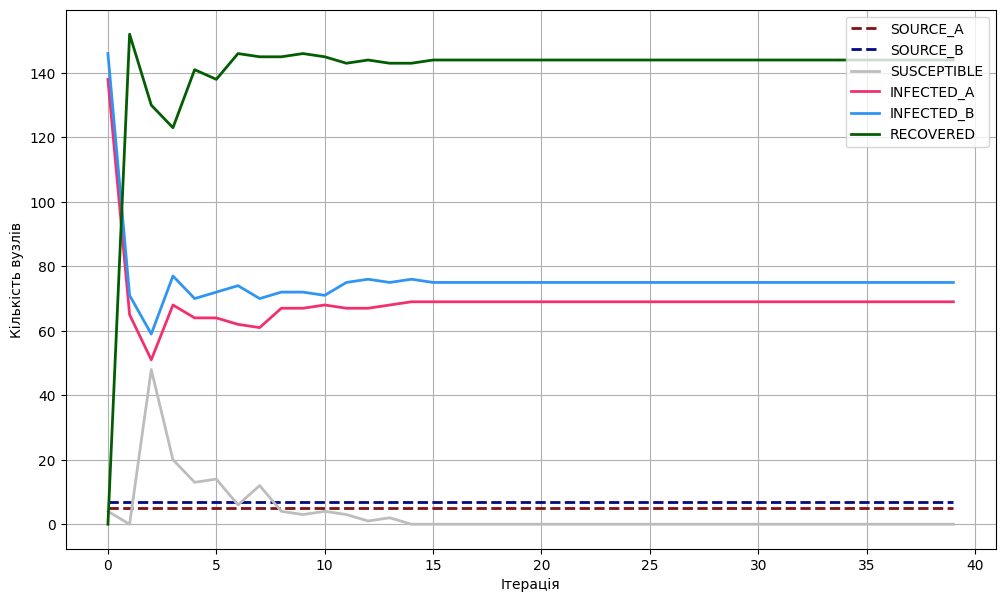

In [8]:

state_counts = {state: [] for state in State}

for step in range(40):
    graph_copy = graph.copy()
    for node in graph.nodes:
        change_states(graph, graph_copy, node)
    for node in graph.nodes:
        graph.nodes[node]["state"] = graph_copy.nodes[node]["state"]

    all_states = [graph.nodes[n]["state"] for n in graph.nodes]
    for state in State:
        state_counts[state].append(all_states.count(state))
    # if step==3:
        # visualize_graph(graph)


plt.figure(figsize=(12, 7))  # <-- збільшений розмір графіка
for state, counts in state_counts.items():
    linestyle = '--' if state in [State.SOURCE_A, State.SOURCE_B] else '-'  # пунктир для джерел
    plt.plot(
        counts,
        label=state.name,
        color=STATE2COLOR[state],
        linewidth=2,
        linestyle=linestyle
    )

plt.xlabel("Ітерація")
plt.ylabel("Кількість вузлів")
# plt.title("Dynamics of Competing Sources Over Time")
plt.legend()
plt.grid(True)
# plt.tight_layout()
plt.show()
